# Imports and Setting up Plotting


In [1]:
import glob
import os
from datetime import date, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
import plotly.express as px

from sklearn import preprocessing

%matplotlib inline

rcParams = {"figure.max_open_warning": 0, "figure.figsize": (15, 8), "axes.grid": True}

plt.rcParams.update(rcParams)
plt.style.use("bmh")

pd.options.display.max_rows = 50

# Loading Data


In [2]:
# Reading CSV files and Loading the data
filepath = os.getcwd() + "/*.csv"
csv_files = glob.glob(filepath)


data = {}

for csv_file in csv_files:
    print("Loading ", csv_file)
    data_key = Path(csv_file).stem
    df = pd.read_csv(csv_file)
    df.set_index("dates", inplace=True)
    df.index = pd.to_datetime(df.index)
    data[data_key] = df

asset_prices = data["asset_prices"]

# Firstly Grab the data by country
countries = ["US", "CA"]
data_labels = ["Unemployment", "IndustrialProduction", "GDP", "HomeSales"]

economic_data = {}

for country in countries:
    tmp_data = {}

    for label in data_labels:
        tmp_data[f"{label}"] = data[f"{country}_{label}"]

    economic_data[f"{country}"] = tmp_data

Loading  /Users/krupal/Downloads/investment_associate_project/project_2/CA_Unemployment.csv
Loading  /Users/krupal/Downloads/investment_associate_project/project_2/CA_IndustrialProduction.csv
Loading  /Users/krupal/Downloads/investment_associate_project/project_2/US_Unemployment.csv
Loading  /Users/krupal/Downloads/investment_associate_project/project_2/US_HomeSales.csv
Loading  /Users/krupal/Downloads/investment_associate_project/project_2/asset_prices.csv
Loading  /Users/krupal/Downloads/investment_associate_project/project_2/US_IndustrialProduction.csv
Loading  /Users/krupal/Downloads/investment_associate_project/project_2/US_GDP.csv
Loading  /Users/krupal/Downloads/investment_associate_project/project_2/CA_GDP.csv
Loading  /Users/krupal/Downloads/investment_associate_project/project_2/CA_HomeSales.csv


## Examining Data


In [3]:
asset_prices

,ES1 Index,PT1 Index,CADUSD Curncy,DXY Curncy
dates,,,,
1980-01-01,NaN,NaN,0.8559,85.820
1980-01-02,NaN,NaN,0.8578,85.320
1980-01-03,NaN,NaN,0.8545,85.260
1980-01-04,NaN,NaN,0.8557,85.230
1980-01-07,NaN,NaN,0.8551,84.790
...,...,...,...,...
2023-01-20,3988.50,1237.2,0.7474,102.012
2023-01-23,4036.50,1244.9,0.7481,102.138
2023-01-24,4032.75,1244.1,0.7480,101.918


In [4]:
economic_data

{'US': {'Unemployment':             actual_value  expected_value  number_of_forecaster
  dates                                                         
  1997-02-07           5.4             5.3                   0.0
  1997-03-07           5.3             5.3                   0.0
  1997-04-04           5.2             5.2                   0.0
  1997-05-02           4.9             5.2                   0.0
  1997-06-06           4.8             5.0                   0.0
  ...                  ...             ...                   ...
  2022-05-06           3.6             3.5                  76.0
  2022-06-03           3.6             3.5                  69.0
  2022-07-08           3.6             3.6                  74.0
  2022-08-05           3.5             3.6                  71.0
  2022-09-02           3.7             3.5                  71.0
  
  [307 rows x 3 columns],
  'IndustrialProduction':             actual_value  expected_value  number_of_forecaster
  dates        

# Building An Indicator


In this example, we assume that the growth rate of GDP is a good indication of the growth of a country's economy. For illustrative and simplicity reasons, we will focus on only this data. With this assumption, again for simplicity, we propose our indicator as just the actual value of GDP growth rate.


In [5]:
us_gdp = economic_data["US"]["GDP"]["actual_value"]  # US GDP growth rate
ca_gdp = economic_data["CA"]["GDP"]["actual_value"]  # Canada GDP growth rate

gdp = pd.concat([us_gdp, ca_gdp], axis=1, sort=True, keys=["US", "CA"])

In [6]:
# our economic indicator is just the GDP growth rate
ca_indicator = ca_gdp
us_indicator = us_gdp

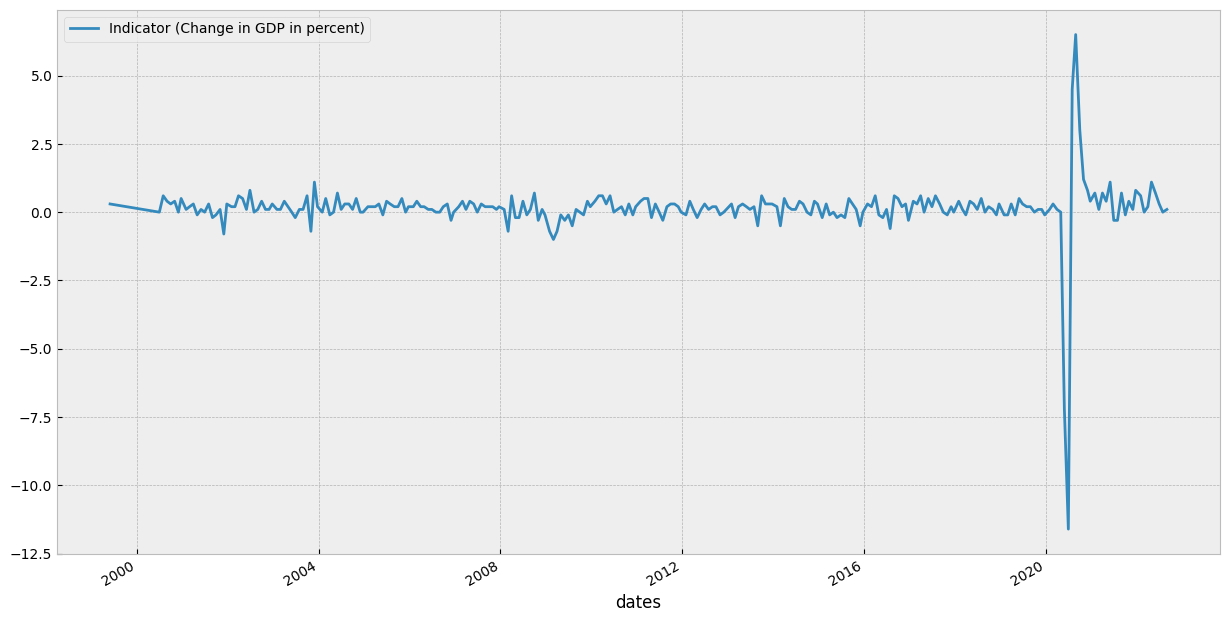

In [7]:
ca_indicator.plot(label="Indicator (Change in GDP in percent)")
plt.legend()

# Building a Trading Signal Using the Indicator


Using the indicator that we have created, we then try to create a trading signal.

We start by thinking how we can trade this strategy.

The most simplistic use of the indicator to trade would be using the indicator as the trading signal without any transformation. In our example, that would mean buy (go long) when the change in GDP is positive, and sell (go short) when the change in GDP is negative. This approach is shown in basic_signal() below.

We encourage you to try some new signals. As an example of how a signal might look like, you can look at the momentum trading signal in the Software Engineering project (Project 1).


In [8]:
def basic_signal(ts):
    # ts is a vector
    signal = pd.DataFrame(
        np.zeros((len(ts.index), 1)), index=ts.index, columns=["signal"]
    )
    signal[ts > 0] = 1
    signal[ts < 0] = -1

    return signal

In [9]:
ca_sgnl = basic_signal(ca_gdp)
us_sgnl = basic_signal(us_gdp)

## Show Performance of the Trading Signal


### Choose the assets you want to trade


In [10]:
# In this case, we are postulating that when the change in GDP is positive,
# both the country's stock market and the country's currency will rise.
ca_assets = ["PT1 Index", "CADUSD Curncy"]
us_assets = ["ES1 Index", "DXY Curncy"]

### Calculate PnL


In [11]:
def calculate_pnl(ret, pos):
    # function to calculate profit and loss
    # we trade at the end of the period, and take profit & loss on the market move next period on our position
    # that's why we are shifting positon vector by one
    return ret.multiply(pos.shift(), axis=0).dropna()

In [12]:
# build the return series for each of the series
ca_returns = asset_prices[ca_assets].pct_change()
us_returns = asset_prices[us_assets].pct_change()

# Resample the Signal into daily signal
ca_daily_pos = ca_sgnl.resample("D").ffill()
us_daily_pos = us_sgnl.resample("D").ffill()

In [13]:
ca_daily_pos

,signal
dates,
1999-05-31,1.0
1999-06-01,1.0
1999-06-02,1.0
1999-06-03,1.0
1999-06-04,1.0
...,...
2022-08-27,0.0
2022-08-28,0.0
2022-08-29,0.0


In [14]:
us_pnl = calculate_pnl(us_returns, us_daily_pos["signal"])
ca_pnl = calculate_pnl(ca_returns, us_daily_pos["signal"])

<Axes: title={'center': 'Cumulative Trading Profit'}, xlabel='dates'>

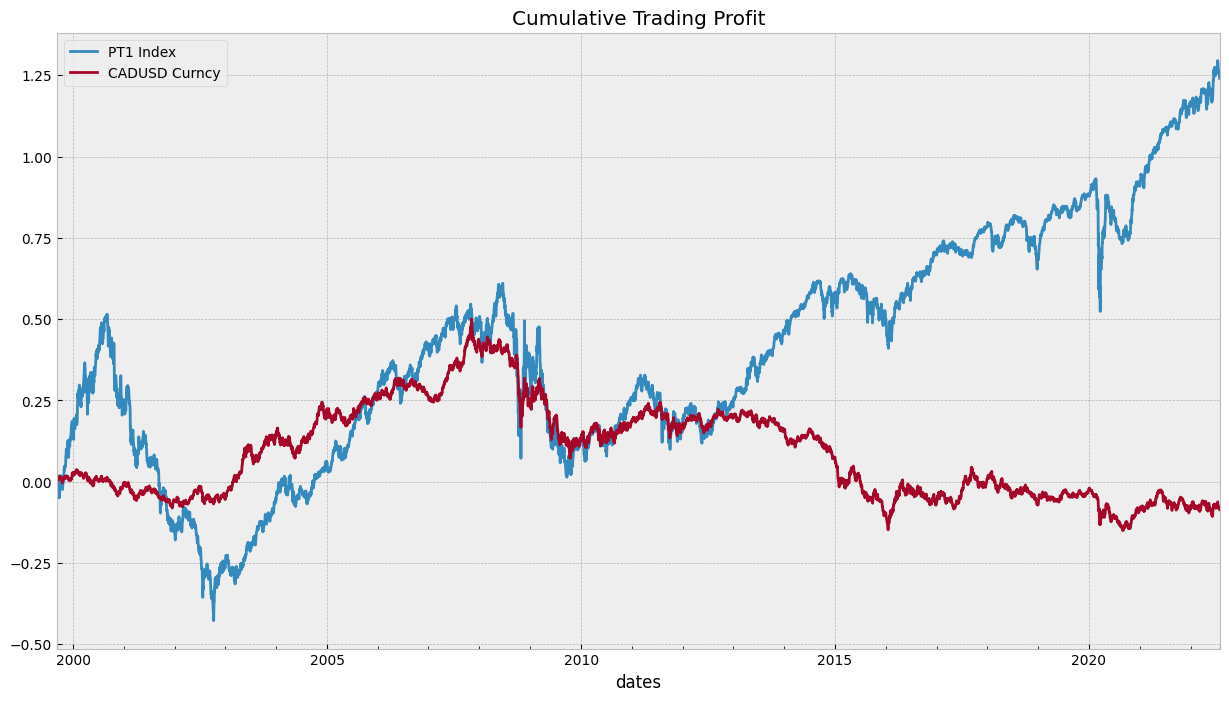

In [15]:
ca_pnl.cumsum().plot(title="Cumulative Trading Profit")

<Axes: title={'center': 'Cumulative Trading Profit'}, xlabel='dates'>

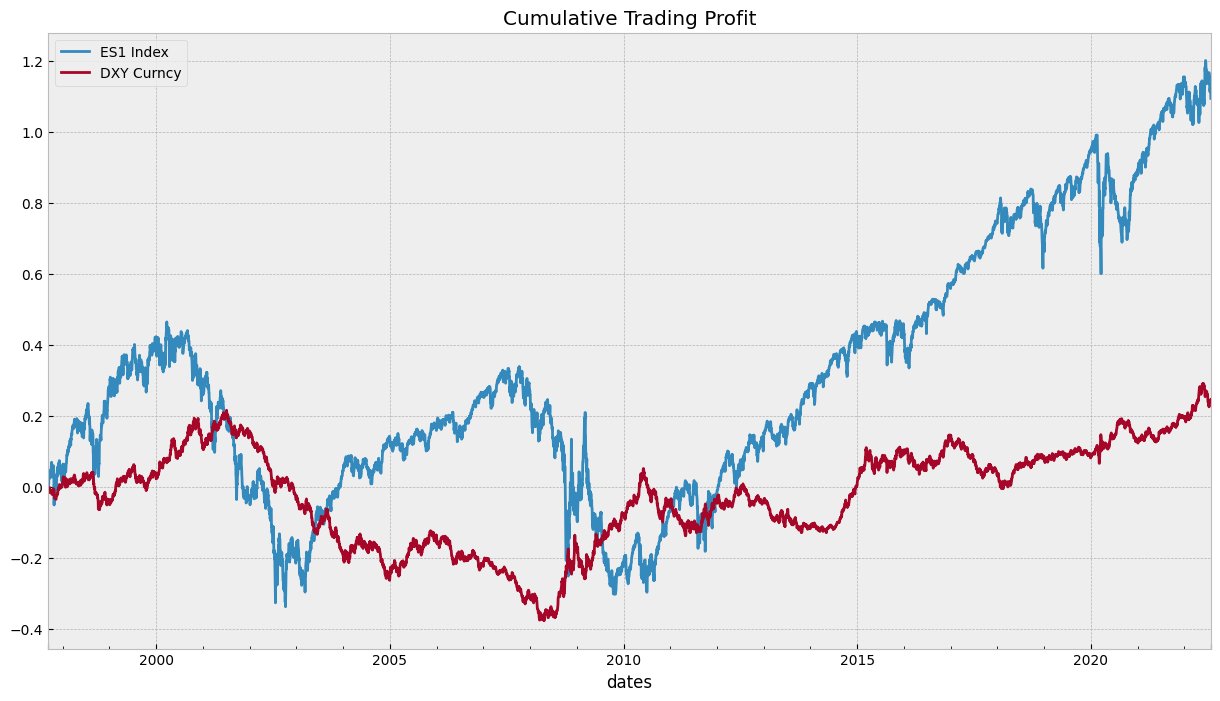

In [16]:
us_pnl.cumsum().plot(title="Cumulative Trading Profit")

## Some thoughts on the performance of the trading signal


Please examine the results of your trading signal and provide some commentary on the performance.

If it performs well. Why? If it doesn't, why not? How can you make it better?

What would be the next steps, if on the job, you are asked to further explore this investigation?
